In [ ]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
# import litellm

# response = litellm.completion(
#     model="gpt-4o-mini-2024-07-18",
#     messages=[{"role": "user", "content": "hi"}],
#     num_retries=10,
# )
# response.choices[0].message.content

In [ ]:
import base64
from openai import OpenAI
import os

# os.environ["HTTPS_PROXY"] = "http://127.0.0.1:7890"
# os.environ["HTTP_PROXY"] = "http://127.0.0.1:7890"

base_url = os.environ.get("OPENAI_BASE_URL", "https://openrouter.ai/api/v1")
api_key = os.environ.get("OPENAI_API_KEY","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")

client = OpenAI(
    api_key=api_key, base_url=base_url
)

# Path to your image
image_path = "..\example_logs\domino_quick_test_20250912_110749\images\step_0.png"

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Getting the base64 string
base64_image = encode_image(image_path)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": '''3D CUBE STACKING PUZZLE

You have 7 3D puzzle pieces and one container.

TASK:
Assemble all pieces into the container to form a solid 3×3×3 cube (27 unit cubes total).

GOAL:
- Fit every piece completely inside the container.
- No gaps, overlaps, or floating pieces.
- The final structure must be stable and form a perfect cube.

ACTION RULE:
- You can move or rotate one piece at a time.
- Continue placing pieces until the cube is fully assembled.


OBJECT MAPPING (object_id → properties):
============================================================
object_id=8, RGB=(201, 88, 0)
object_id=7, RGB=(23, 115, 206)
object_id=6, RGB=(0, 87, 43)
object_id=5, RGB=(222, 197, 12)
object_id=4, RGB=(0, 42, 113)
object_id=3, RGB=(169, 27, 0)
object_id=2, RGB=(153, 48, 97)
============================================================
Total movable objects: 7

Now, what's your next action?'''
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}"
                    }
                }
            ],
        }
    ],
    model="gpt-4o",
    tools=[{'type': 'function', 'function': {'name': 'move_object', 'description': 'Move an object to a specific 3D position in the workspace. The object will be teleported to the target position instantly. CONSTRAINTS: Position coordinates should be within the workspace bounds (typically -2.0 to 2.0 meters for x and y, 0.0 to 2.0 meters for z). Objects moved above ground (z > 0) will fall under gravity.', 'parameters': {'type': 'object', 'properties': {'object_id': {'type': 'integer', 'description': 'Unique object_id (integer) of the object to move. Get this from the observation state.'}, 'position': {'type': 'array', 'items': {'type': 'number'}, 'minItems': 3, 'maxItems': 3, 'description': 'Target position [x, y, z] in meters. Example: [0.5, 0.2, 0.1]. Ensure z >= 0 to keep objects above ground.'}}, 'required': ['object_id', 'position']}}}, {'type': 'function', 'function': {'name': 'rotate_object', 'description': "Rotate an object around a specified axis by a given angle. The rotation is applied relative to the object's current orientation. CONSTRAINTS: Angle should typically be between -180 and 180 degrees. Common angles: 90° for quarter turn, 180° for half turn.", 'parameters': {'type': 'object', 'properties': {'object_id': {'type': 'integer', 'description': 'Unique object_id (integer) of the object to rotate. Get this from the observation state.'}, 'axis': {'type': 'string', 'enum': ['x', 'y', 'z'], 'description': "Rotation axis: 'x' for pitch, 'y' for yaw, 'z' for roll"}, 'angle': {'type': 'number', 'description': 'Rotation angle in degrees (positive = counter-clockwise when viewing along the axis). Typical range: -180 to 180.'}}, 'required': ['object_id', 'axis', 'angle']}}}, {'type': 'function', 'function': {'name': 'observe', 'description': 'Change camera viewpoint to observe the scene from a different angle. The camera rotates around the center of the scene at a fixed distance. Use this to inspect objects from different perspectives. CONSTRAINTS: Angle wraps around at 360 degrees (0° = front view, 90° = right side, 180° = back, 270° = left side).', 'parameters': {'type': 'object', 'properties': {'angle': {'type': 'number', 'default': 0.0, 'description': 'Camera rotation angle in degrees around the scene center. 0° = front, 90° = right, 180° = back, 270° = left. Range: 0-360 (wraps around).'}}, 'required': ['angle']}}}, {'type': 'function', 'function': {'name': 'finish', 'description': 'Signal that you have completed the task successfully. ONLY call this when you believe all task objectives have been fully achieved. The system will evaluate your result after this call.', 'parameters': {'type': 'object', 'properties': {}, 'required': []}}}, {'type': 'function', 'function': {'name': 'place_into_container', 'description': "Place a puzzle piece into the container at a specified offset position relative to the container's center. This is a convenient alternative to move_object when placing pieces into the container. The piece will be positioned relative to the container's coordinate system. CONSTRAINTS: Offsets must be small to keep pieces inside the container. Use offset_z to stack pieces vertically.", 'parameters': {'type': 'object', 'properties': {'object_id': {'type': 'integer', 'description': "Unique object_id (integer) of the puzzle piece to place. Get this from the observation state. Do NOT use the container's object_id."}, 'offset_x': {'type': 'number', 'description': 'X offset from container center in meters. Positive = right, negative = left. RANGE: -0.1 to 0.1 (must keep piece inside container).', 'default': 0.0}, 'offset_y': {'type': 'number', 'description': 'Y offset from container center in meters. Positive = forward, negative = backward. RANGE: -0.1 to 0.1 (must keep piece inside container).', 'default': 0.0}, 'offset_z': {'type': 'number', 'description': 'Z offset from container bottom in meters. Use this for vertical stacking. RANGE: 0.0 to 0.15. Start from 0.0 for bottom layer, increase for higher layers.', 'default': 0.0}}, 'required': ['object_id']}}}],
    tool_choice='auto',
)
print(chat_completion.choices[0].message)

ChatCompletionMessage(content="To begin assembling the 3x3x3 cube within the container, I'll move and place the first piece. Let's start with object_id=2 (the piece with RGB=(153, 48, 97)). I'll place it into the container at the bottom layer. \n\nI'll proceed with the following steps:\n\n1. Place object_id=2 into the container at offset (0, 0, 0).", refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[ChatCompletionMessageFunctionToolCall(id='call_7CIwIBXk4WTLQOcQrnAFcZ2m', function=Function(arguments='{"object_id":2,"offset_x":0,"offset_y":0,"offset_z":0}', name='place_into_container'), type='function', index=0)], reasoning=None)


{1: {-1: (0.7882400155067444, 0.3450999855995178, 0.0, 1.0)}, 2: {-1: (0.09019999951124191, 0.45489999651908875, 0.8117600083351135, 1.0)}, 3: {-1: (0.0, 0.3411799967288971, 0.16863000392913818, 1.0)}, 4: {-1: (0.8705899715423584, 0.7725499868392944, 0.05098000168800354, 1.0)}, 5: {-1: (0.0, 0.16471000015735626, 0.4431400001049042, 1.0)}, 6: {-1: (0.6627500057220459, 0.10980000346899033, 0.0, 1.0)}, 7: {-1: (0.6000000238418579, 0.18824000656604767, 0.3843100070953369, 1.0)}, 8: {-1: (0.2117599993944168, 0.2117599993944168, 0.2117599993944168, 1.0)}}


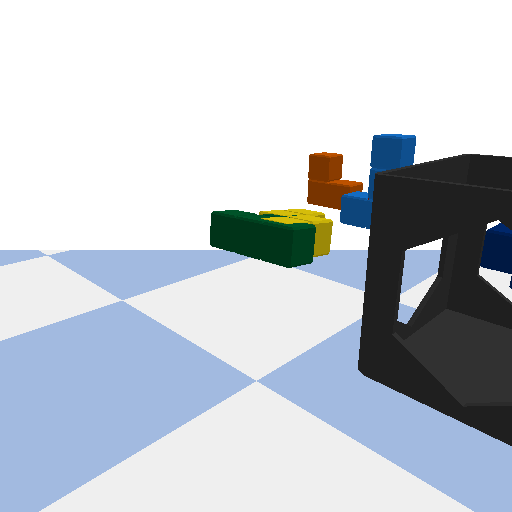

In [ ]:
import pybullet as p
import pybullet_data
import numpy as np
from PIL import Image
import os
import glob
from IPython.display import display

# 通过环境变量或开关控制是否使用 GUI
USE_GUI = os.environ.get("PYBULLET_USE_GUI", "0") == "1"
RENDERER = os.environ.get("PYBULLET_RENDERER", "TINY").upper()  # 可选: TINY / OPENGL

# 连接到 pybullet（GUI 或 DIRECT）
physicsClient = p.connect(p.GUI if USE_GUI else p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# 加载地面与基本物理
planeId = p.loadURDF("plane.urdf")
p.setGravity(0, 0, -9.8)

# 查找并加载 URDF 模型
urdf_root = r"/mnt/moonfs/wuyuhao-m2/wyh/VisualReasonBench/src/phyvpuzzle/environment/phobos_models/3x3-stacking-puzzle"
urdf_files = []
for root, dirs, files in os.walk(urdf_root):
    for file in files:
        if file.endswith(".urdf"):
            urdf_files.append(os.path.join(root, file))

urdf_files.sort()

loaded_ids = []
num_per_row = int(np.ceil(np.sqrt(len(urdf_files))))
spacing = 0.3
for idx, urdf_path in enumerate(urdf_files):
    row = idx // num_per_row
    col = idx % num_per_row
    x = (col - num_per_row / 2) * spacing
    y = (row - num_per_row / 2) * spacing
    z = 0.5
    try:
        obj_id = p.loadURDF(urdf_path, [x, y, z])
        loaded_ids.append(obj_id)
    except Exception as e:
        print(f"Failed to load {urdf_path}: {e}")

# 收集每个对象的可视化颜色
obj_color_dict = {}
for obj_id in loaded_ids:
    visual_shapes = p.getVisualShapeData(obj_id)
    if visual_shapes:
        link_colors = {}
        for vs in visual_shapes:
            link_index = vs[1]
            color = vs[7]  # rgbaColor
            link_colors[link_index] = color
        obj_color_dict[obj_id] = link_colors
    else:
        obj_color_dict[obj_id] = {}

print(obj_color_dict)

# 相机参数
width, height = 512, 512
view_matrix = p.computeViewMatrix(
    cameraEyePosition=[1, 1, 1],
    cameraTargetPosition=[0, 0, 0.5],
    cameraUpVector=[0, 0, 1]
)
fov = 60
aspect = width / height
near = 0.1
far = 3.1
projection_matrix = p.computeProjectionMatrixFOV(
    fov=fov,
    aspect=aspect,
    nearVal=near,
    farVal=far
)

# 小步推进让物体稳定
for _ in range(10):
    p.stepSimulation()

# 渲染器选择
renderer_flag = p.ER_TINY_RENDERER if RENDERER == "TINY" else p.ER_BULLET_HARDWARE_OPENGL

# 渲染图像
img_arr = p.getCameraImage(
    width=width,
    height=height,
    viewMatrix=view_matrix,
    projectionMatrix=projection_matrix,
    renderer=renderer_flag
)

rgb_array = np.reshape(img_arr[2], (height, width, 4))[:, :, :3]
img = Image.fromarray(rgb_array.astype(np.uint8))

# 在 Jupyter 内联显示（而不是系统弹窗）
display(img)

# 若在脚本中也想弹窗，可按需启用：
# img.show()

# 断开连接
p.disconnect()


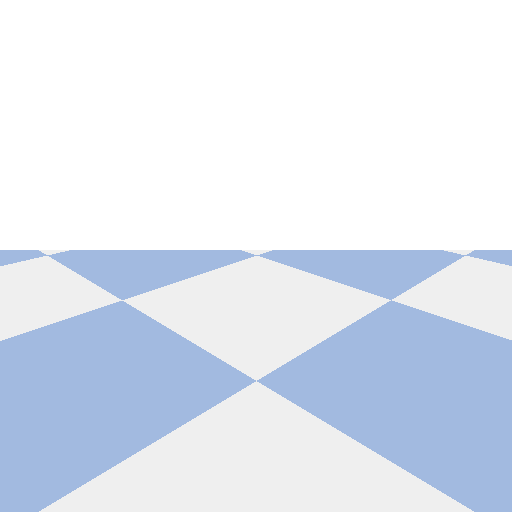

In [ ]:
img.show()

In [ ]:
import numpy as np
seg = img_arr[4]
crop = seg[290:340, 230:290]
id_counts = np.bincount(crop[crop >= 0].flatten())
if len(id_counts) > 0:
    target_id = np.argmax(id_counts)
    print("AI 看到的方块对应物理ID:", target_id)


AI 看到的方块对应物理ID: 0


In [ ]:
img2 = img.crop((190, 270, 270, 3100))
img2.show()

In [ ]:
crop

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
print(np.unique(img_arr[4]))

[-1  0  1  2  3  4  5  6  8]


In [ ]:
visual_shapes

((8,
  -1,
  5,
  (0.005, 0.005, 0.005),
  b'C:\\Users\\smj81\\Desktop\\VisualReasonBench\\src\\phyvpuzzle\\environment\\phobos_models\\3x3-stacking-puzzle\\obj_8\\urdf/../meshes/obj/bt_cube3x3_box.obj',
  (0.29408, 0.66932, 0.07707),
  (0.0, 0.0, 0.0, 1.0),
  (0.2117599993944168, 0.2117599993944168, 0.2117599993944168, 1.0)),)

In [ ]:
from math import ceil
from typing import List

def majority_elements_n_over_k(nums: List[int], k: int) -> List[int]:
    n = len(nums)
    if not nums or k <= 1:
        return []

    # 第一轮：投票筛选候选人
    cand = {}
    for x in nums:
        if x in cand:
            cand[x] += 1
        elif len(cand) < k - 1:
            cand[x] = 1
        else:
            drop = []
            for v in cand:
                cand[v] -= 1
                if cand[v] == 0:
                    drop.append(v)
            for v in drop:
                del cand[v]

    # 第二轮：验证真实出现次数
    real_count = {v: 0 for v in cand}
    for x in nums:
        if x in real_count:
            real_count[x] += 1

    threshold = ceil(n / k)
    return [v for v, c in real_count.items() if c >= threshold]

print(majority_elements_n_over_k([2, 0, 1, 2], 3))

[2]


## Control

In [ ]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
import pybullet as p
import pybullet_data
import os
import time
import math

# 启动 PyBullet GUI 并设置基础环境（参考 base_env.py 的基础做法）
client_id = p.connect(p.GUI)

# 重置并设置搜索路径、重力、时间步与实时仿真
p.resetSimulation(physicsClientId=client_id)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.81, physicsClientId=client_id)
p.setTimeStep(1.0/240.0, physicsClientId=client_id)
try:
    p.setPhysicsEngineParameter(
        fixedTimeStep=1.0/240.0,
        numSubSteps=4,
        numSolverIterations=50,
        physicsClientId=client_id,
    )
except Exception:
    pass
p.setRealTimeSimulation(0, physicsClientId=client_id)

# 加载地面
plane_id = p.loadURDF("plane.urdf", physicsClientId=client_id)

# 加载 luban-3-piece 下的所有 piece URDF（先冻结，后排布，最后恢复质量）
root_dir = r"C:\\Users\\smj81\\Desktop\\VisualReasonBench\\src\\phyvpuzzle\\environment\\phobos_models\\luban-3-piece"
urdf_paths = [
    os.path.join(root_dir, "piece_1", "urdf", "piece_1.urdf"),
    os.path.join(root_dir, "piece_2", "urdf", "piece_2.urdf"),
    os.path.join(root_dir, "piece_3", "urdf", "piece_3.urdf"),
]

pieces = []  # [{id, mass}]
for urdf_path in urdf_paths:
    if not os.path.isfile(urdf_path):
        print(f"URDF not found: {urdf_path}")
        continue
    try:
        obj_id = p.loadURDF(urdf_path, basePosition=[0, 0, 0.5], physicsClientId=client_id)
        # 记录原始质量
        dyn = p.getDynamicsInfo(obj_id, -1)
        orig_mass = dyn[0] if dyn is not None else 1.0
        # 冻结：设置质量为 0 并清零速度，避免刚加载时炸开
        p.changeDynamics(obj_id, -1, mass=0.0)
        p.resetBaseVelocity(obj_id, [0, 0, 0], [0, 0, 0])
        pieces.append({"id": obj_id, "mass": orig_mass})
    except Exception as e:
        print(f"Failed to load {urdf_path}: {e}")

print(f"Loaded {len(pieces)} luban pieces:", [x["id"] for x in pieces])

# 基于 AABB 估计尺寸并安全排布（避免初始穿插引发爆炸）
if pieces:
    # 计算每个件体的包围盒尺寸
    extents = []
    for piece in pieces:
        aabb = p.getAABB(piece["id"])  # ((minX,minY,minZ),(maxX,maxY,maxZ))
        size = [aabb[1][i] - aabb[0][i] for i in range(3)]
        extents.append(size)
    max_size = max((max(s[0], s[1], s[2]) for s in extents), default=0.2)
    spacing = max_size + 0.05  # 留一定余量

    # 按水平直线排布
    start_x = -spacing * (len(pieces) - 1) / 2.0
    y = 0.0
    z = 0.3
    for i, piece in enumerate(pieces):
        x = start_x + i * spacing
        p.resetBasePositionAndOrientation(piece["id"], [x, y, z], [0, 0, 0, 1])

    # 让位置更新生效几步
    for _ in range(10):
        p.stepSimulation()

    # 恢复质量为更大值以降低拖拽弹飞风险，并清零速度
    for piece in pieces:
        target_mass = max(piece["mass"], 1.0) * 5.0
        p.changeDynamics(piece["id"], -1, mass=target_mass)
        p.resetBaseVelocity(piece["id"], [0, 0, 0], [0, 0, 0])

# 进入交互循环：启用实时仿真，按 'q' 退出
p.setRealTimeSimulation(1, physicsClientId=client_id)
print("Interactive mode: press 'q' to quit. Press 1/2/3 to select piece, 'u' to unfreeze all.")

# 建立索引便于快捷键 1/2/3 选择
piece_ids = [piece["id"] for piece in pieces]
orig_mass_map = {piece["id"]: piece["mass"] for piece in pieces}
heavy_mass_map = {pid: max(orig_mass_map[pid], 1.0) * 5.0 for pid in piece_ids}
current_active = None  # 当前被“选中”的件体 id


def freeze_others(active_id):
    global current_active
    current_active = active_id
    for pid in piece_ids:
        if pid != active_id:
            p.changeDynamics(pid, -1, mass=0.0, linearDamping=0.99, angularDamping=0.99)
            p.resetBaseVelocity(pid, [0, 0, 0], [0, 0, 0])
        else:
            p.changeDynamics(pid, -1, mass=heavy_mass_map[pid], linearDamping=0.2, angularDamping=0.2)
            p.resetBaseVelocity(pid, [0, 0, 0], [0, 0, 0])


def unfreeze_all():
    global current_active
    current_active = None
    for pid in piece_ids:
        p.changeDynamics(pid, -1, mass=heavy_mass_map[pid], linearDamping=0.2, angularDamping=0.2)
        p.resetBaseVelocity(pid, [0, 0, 0], [0, 0, 0])

move_step = 0.01  # 每次按键位移（米），可根据需要调大/调小
rot_step_deg = 5.0  # 每次按键旋转（度）

while p.isConnected():
    keys = p.getKeyboardEvents()
    if ord('p') in keys and keys[ord('p')] & p.KEY_WAS_TRIGGERED:
        break

    # 快捷键：1/2/3 选择件体，其他固定；'u' 取消固定
    if len(piece_ids) >= 1 and (ord('1') in keys and keys[ord('1')] & p.KEY_WAS_TRIGGERED):
        freeze_others(piece_ids[0])
    if len(piece_ids) >= 2 and (ord('2') in keys and keys[ord('2')] & p.KEY_WAS_TRIGGERED):
        freeze_others(piece_ids[1])
    if len(piece_ids) >= 3 and (ord('3') in keys and keys[ord('3')] & p.KEY_WAS_TRIGGERED):
        freeze_others(piece_ids[2])
    if ord('u') in keys and keys[ord('u')] & p.KEY_WAS_TRIGGERED:
        unfreeze_all()

    # QAZ 控制 XYZ 平移；WSX 控制绕 XYZ 旋转（小写为正方向，按住 Shift 大写为负方向）
    if current_active is not None and current_active in piece_ids:
        pos, orn = p.getBasePositionAndOrientation(current_active)
        x, y, z = list(pos)

        # 平移控制（Q/A/Z => +X/+Y/+Z，Q/A/Z 的大写 => -X/-Y/-Z）
        if ord('q') in keys and (keys[ord('q')] & (p.KEY_IS_DOWN | p.KEY_WAS_TRIGGERED)):
            x += move_step
        if ord('Q') in keys and (keys[ord('Q')] & (p.KEY_IS_DOWN | p.KEY_WAS_TRIGGERED)):
            x -= move_step
        if ord('a') in keys and (keys[ord('a')] & (p.KEY_IS_DOWN | p.KEY_WAS_TRIGGERED)):
            y += move_step
        if ord('A') in keys and (keys[ord('A')] & (p.KEY_IS_DOWN | p.KEY_WAS_TRIGGERED)):
            y -= move_step
        if ord('z') in keys and (keys[ord('z')] & (p.KEY_IS_DOWN | p.KEY_WAS_TRIGGERED)):
            z += move_step
        if ord('Z') in keys and (keys[ord('Z')] & (p.KEY_IS_DOWN | p.KEY_WAS_TRIGGERED)):
            z -= move_step

        # 旋转控制（W/S/X 分别绕 X/Y/Z 轴：小写 +，大写 -）
        ex, ey, ez = p.getEulerFromQuaternion(orn)
        step_rad = math.radians(rot_step_deg)
        if ord('w') in keys and (keys[ord('w')] & (p.KEY_IS_DOWN | p.KEY_WAS_TRIGGERED)):
            ex += step_rad
        if ord('W') in keys and (keys[ord('W')] & (p.KEY_IS_DOWN | p.KEY_WAS_TRIGGERED)):
            ex -= step_rad
        if ord('s') in keys and (keys[ord('s')] & (p.KEY_IS_DOWN | p.KEY_WAS_TRIGGERED)):
            ey += step_rad
        if ord('S') in keys and (keys[ord('S')] & (p.KEY_IS_DOWN | p.KEY_WAS_TRIGGERED)):
            ey -= step_rad
        if ord('x') in keys and (keys[ord('x')] & (p.KEY_IS_DOWN | p.KEY_WAS_TRIGGERED)):
            ez += step_rad
        if ord('X') in keys and (keys[ord('X')] & (p.KEY_IS_DOWN | p.KEY_WAS_TRIGGERED)):
            ez -= step_rad

        new_orn = p.getQuaternionFromEuler([ex, ey, ez])
        p.resetBasePositionAndOrientation(current_active, [x, y, z], new_orn)
        p.resetBaseVelocity(current_active, [0, 0, 0], [0, 0, 0])

    p.stepSimulation()
    time.sleep(1.0/240.0)

p.disconnect()


Loaded 3 luban pieces: [1, 2, 3]
Interactive mode: press 'q' to quit. Press 1/2/3 to select piece, 'u' to unfreeze all.
